In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

## Problem 24

I use the numerically stable version of the gram schmidt algorithm i.e.

$$
\begin{align*}
u_k^{(1)} &= v_k - \operatorname{proj}_{u_1}(v_k),\\
u_k^{(2)} &= u_k^{(1)} - \operatorname{proj}_{u_2}\bigl(u_k^{(1)}\bigr),\\
&\quad\vdots\nonumber\\
u_k^{(k-2)} &= u_k^{(k-3)} - \operatorname{proj}_{u_{k-2}}\bigl(u_k^{(k-3)}\bigr),\\
u_k^{(k-1)} &= u_k^{(k-2)} - \operatorname{proj}_{u_{k-1}}\bigl(u_k^{(k-2)}\bigr),\\
e_k &= \frac{u_k^{(k-1)}}{\bigl\lVert u_k^{(k-1)}\bigr\rVert}.
\end{align*}
$$

### References

<https://en.wikipedia.org/wiki/QR_decomposition>

<https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process>

<https://en.wikipedia.org/wiki/Projection_(linear_algebra)>


In [2]:
def projection(u, a):
    """
    Project vector a onto vector u.
    """
    return (u @ a) / (u @ u) * u

def weighted_norm(vector, Matrix):
    return np.sqrt(vector.T @ Matrix @ vector)

In [3]:
def modified_gram_schmidt(V: np.ndarray, tol=1e-14):
    """
    Perform Gram-Schmidt orthogonalization on an array of column vectors.
    """
    m, n = V.shape
    U = np.zeros((m, n))

    for k in range(n):
        u = V[:, k]
        for j in range(k):
            prod = u @ U[:, j]
            u = u - prod * U[:, j]
        norm_u = norm(u)
        if norm_u < tol:
            U[:, k] = np.zeros(m)
        else:
            U[:, k] = u / norm_u
    return U

Implementation with the R matrix, the only difference is that we save the prod variable

In [4]:
def QR_MGS(V: np.ndarray, tol=1e-14):
    """
    Perform Gram-Schmidt orthogonalization on an array of column vectors.
    Returns Q, R where A = QR
    """
    m, n = V.shape
    U = np.zeros((m, n))
    R = np.zeros((n, n))

    for k in range(n):
        u = V[:, k]
        for j in range(k):
            R[j, k] = U[:, j] @ V[:, k]
            u = u - R[j, k] * U[:, j]
        norm_u = norm(u)
        if norm_u < tol:
            U[:, k] = np.zeros(m)
            R[k, k] = 0
        else:
            U[:, k] = u / norm_u
            R[k, k] = norm_u
    return U, R

In [5]:
A = np.random.rand(5, 4)
# create a non full rank matrix
A[:,3] = A[:,0] + A[:,1] + A[:,2]
Q, R = QR_MGS(A)
print("Q^T Q:\n", np.round(Q.T @ Q, 6))
print("Reconstruction error:\n", norm(A - Q @ R))

Q^T Q:
 [[ 1.  0. -0.  0.]
 [ 0.  1. -0.  0.]
 [-0. -0.  1.  0.]
 [ 0.  0.  0.  0.]]
Reconstruction error:
 2.2894564718824207e-15


Only changed the two times where we calculated the inner product and the norm

In [6]:
def QR_MGS_weighted(V: np.ndarray, M, tol=1e-14):
    """
    Perform Modified Gram-Schmidt orthogonalization on the columns of V
    with respect to the M-weighted inner product <x, y>_M = x^T M y,
    returning U and R such that V = U @ R and U^T M U = I.
    """
    m, n = V.shape
    U = np.zeros((m, n))
    R = np.zeros((n, n))

    for k in range(n):
        u = V[:, k]
        for j in range(k):
            R[j, k] = U[:, j].T @ M @ V[:, k]
            u = u - R[j, k] * U[:, j]
        norm_u = weighted_norm(u, M)
        if norm_u < tol:
            U[:, k] = np.zeros(m)
            R[k, k] = 0
        else:
            U[:, k] = u / norm_u
            R[k, k] = norm_u
    return U, R

In [7]:
A = np.random.rand(5, 3)
U, R = QR_MGS(A)
print("U^T U:\n", np.round(U.T @ U, 6))
print("Reconstruction error:\n", norm(A - U @ R))

U^T U:
 [[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]
Reconstruction error:
 1.6653345369377348e-16


In [8]:
# Example usage
V = np.random.rand(5, 3)
# build a positive-definite weight matrix M
B = np.random.rand(5, 5)
M = B.T @ B + np.eye(5)*1e-3

U, R = QR_MGS_weighted(V, M)
# Check M-orthonormality: U^T M U ≈ I
print("U^T M U:\n", np.round(U.T @ M @ U, 6))
# Reconstruction error in standard norm: ||V - U R||
print("Reconstruction error:\n", np.linalg.norm(V - U @ R))


U^T M U:
 [[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]
Reconstruction error:
 9.614813431917819e-17


## Problem 25


In [9]:
def make_tridiagonal(n, a, b, c):
    diag = np.diag(b * np.ones(n))
    sub_diag = np.diag(a * np.ones(n-1), -1)
    sup_diag = np.diag(c * np.ones(n-1), 1)
    return sub_diag + diag + sup_diag

In [10]:
def cg_like_method(A, b, x0, max_iter=10000):
    
    n = A.shape[0]
    assert len(b) == n
    assert len(x0) == n
    assert A.shape[0] == A.shape[1]

    x = np.zeros((max_iter + 1, n))
    r = np.zeros((max_iter + 1, n))
    p = np.zeros((max_iter + 1, n))
    
    x[0] = x0
    r[0] = b - A @ x0
    p[0] = r[0] / weighted_norm(r[0], A)

    for i in range(max_iter):
        alpha = p[i] @ r[i]
        x[i+1] = x[i] + alpha * p[i]
        r[i+1] = b - A @ x[i+1]
        Q,_ = QR_MGS_weighted(r[:i+2].T, A)
        p[i+1] = Q[:, -1]
    return x, r

In [11]:
def steepest_gradient_descent(A, b, x0, max_iter=10000):
    n = A.shape[0]
    assert len(b) == n
    assert len(x0) == n
    assert A.shape[0] == A.shape[1]

    x = np.zeros((max_iter + 1, n))
    r = np.zeros((max_iter + 1, n))

    x[0] = x0
    r[0] = b - A @ x0

    for i in range(max_iter):
        Ar = A @ r[i]
        alpha = (r[i].T @ r[i]) / ( r[i].T @ Ar ) 
        x[i+1] = x[i] + alpha * r[i]
        r[i+1] = r[i] - alpha * Ar
  
    return x, r

In [12]:
n = 100
A = make_tridiagonal(n, -1, 2, -1)
m = n + 10
b = np.ones(n)
x0 = np.random.rand(n)
x_sol = np.linalg.solve(A, b)

x, residuals = cg_like_method(A, b, x0, max_iter=m)
x_steepest, residuals_steepest = steepest_gradient_descent(A, b, x0, max_iter=m)

In [13]:
error_norm_cg_like = norm(x_sol - x, axis=1)
error_A_norm_cg_like = np.array([weighted_norm(error, A) for error in x_sol - x])
residual_norm_cg_like = norm(residuals, axis=1)
residual_A_norm_cg_like = np.array([weighted_norm(r, A) for r in residuals])

In [14]:
error_norm_steepest = norm(x_sol - x_steepest, axis=1)
error_A_norm_steepest = np.array([weighted_norm(error, A) for error in x_sol - x_steepest])
residual_norm_steepest = norm(residuals_steepest, axis=1)
residual_A_norm_steepest = np.array([weighted_norm(r, A) for r in residuals_steepest])

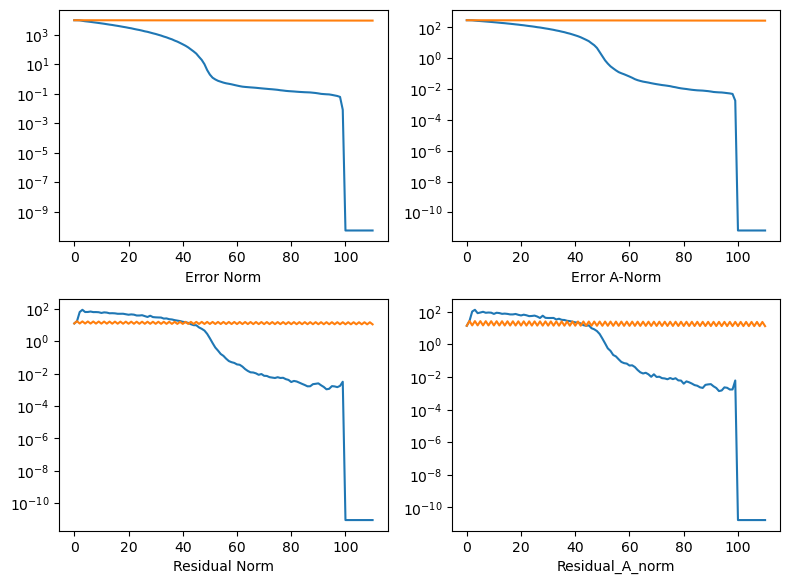

In [15]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.semilogy(error_norm_cg_like)
plt.semilogy(error_norm_steepest)
plt.xlabel("Error Norm")

plt.subplot(2, 2, 2)
plt.semilogy(error_A_norm_cg_like)
plt.semilogy(error_A_norm_steepest)
plt.xlabel("Error A-Norm")

plt.subplot(2, 2, 3)
plt.semilogy(residual_norm_cg_like)
plt.semilogy(residual_norm_steepest)
plt.xlabel("Residual Norm")

plt.subplot(2, 2, 4)
plt.semilogy(residual_A_norm_cg_like)
plt.semilogy(residual_A_norm_steepest)
plt.xlabel("Residual_A_norm")

plt.tight_layout()
plt.show()

## Problem 26

In [16]:
def cg_method(A, b, x0, max_iter=10000):
    n = A.shape[0]
    assert len(b) == n
    assert len(x0) == n
    assert A.shape[0] == A.shape[1]

    # Save all iterates, would not be done in production code
    x = np.zeros((max_iter + 1, n))
    r = np.zeros((max_iter + 1, n))
    p = np.zeros((max_iter + 1, n))
    
    x[0] = x0
    r[0] = b - A @ x0
    p[0] = r[0]
    r_norm_squared = r[0].T @ r[0]
    for i in range(max_iter):
        alpha = r_norm_squared / (p[i].T @ A @ p[i])
        x[i+1] = x[i] + alpha * p[i]
        r[i+1] = r[i] - alpha * A @ p[i]
        r_norm_squared_new = r[i+1].T @ r[i+1]
        beta = r_norm_squared_new / r_norm_squared
        r_norm_squared = r_norm_squared_new
        p[i+1] = r[i+1] + beta * p[i] 
    return x, r

In [17]:
n = 100
A = make_tridiagonal(n, -1, 2, -1)
# To see what happens with a non SPD matrix, uncomment the next line
# A[0] = -A[0]
m = n + 10
b = np.ones(n)
x0 = np.random.rand(n)
x_sol = np.linalg.solve(A, b)

x, residuals = cg_method(A, b, x0, max_iter=m)
x_steepest, residuals_steepest = steepest_gradient_descent(A, b, x0, max_iter=m)

In [18]:
error_norm_cg = norm(x_sol - x, axis=1)
error_A_norm_cg = np.array([weighted_norm(error, A) for error in x_sol - x])
residual_norm_cg = norm(residuals, axis=1)
residual_A_norm_cg = np.array([weighted_norm(r, A) for r in residuals])

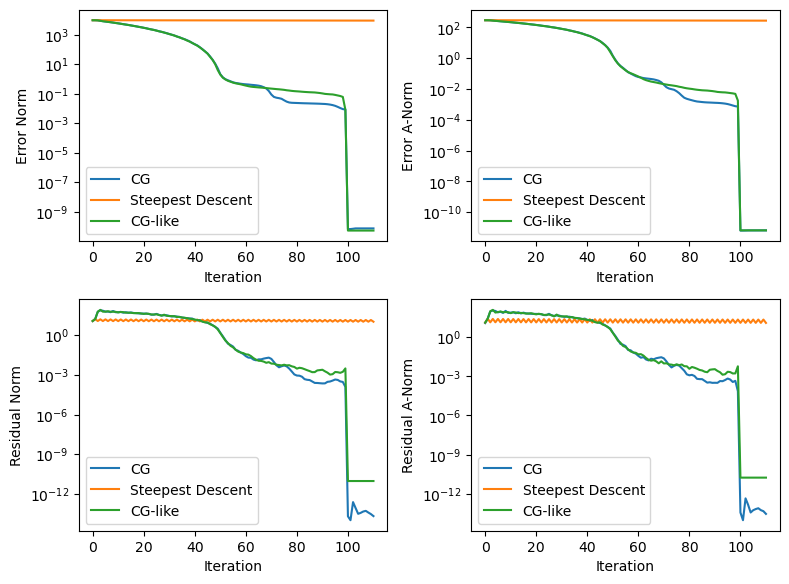

In [19]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.semilogy(error_norm_cg, label="CG")
plt.semilogy(error_norm_steepest, label="Steepest Descent")
plt.semilogy(error_norm_cg_like, label="CG-like")
plt.xlabel("Iteration")
plt.ylabel("Error Norm")
plt.legend()

plt.subplot(2, 2, 2)
plt.semilogy(error_A_norm_cg, label="CG")
plt.semilogy(error_A_norm_steepest, label="Steepest Descent")
plt.semilogy(error_A_norm_cg_like, label="CG-like")
plt.xlabel("Iteration")
plt.ylabel("Error A-Norm")
plt.legend()

plt.subplot(2, 2, 3)
plt.semilogy(residual_norm_cg, label="CG")
plt.semilogy(residual_norm_steepest, label="Steepest Descent")
plt.semilogy(residual_norm_cg_like, label="CG-like")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.legend()

plt.subplot(2, 2, 4)
plt.semilogy(residual_A_norm_cg, label="CG")
plt.semilogy(residual_A_norm_steepest, label="Steepest Descent")
plt.semilogy(residual_A_norm_cg_like, label="CG-like")
plt.xlabel("Iteration")
plt.ylabel("Residual A-Norm")
plt.legend()

plt.tight_layout()
plt.show()

## Problem 27

TODO: Plot theoretical estimates

In [20]:
B = make_tridiagonal(n, 1, 4, 1)
x_sol = np.linalg.solve(B, b)
x_cg, residuals_cg = cg_method(B, b, x0, max_iter=m)
x_steepest, residuals_steepest = steepest_gradient_descent(B, b, x0, max_iter=m)

error_norm_cg = norm(x_sol - x_cg, axis=1)
error_norm_steepest = norm(x_sol - x_steepest, axis=1)

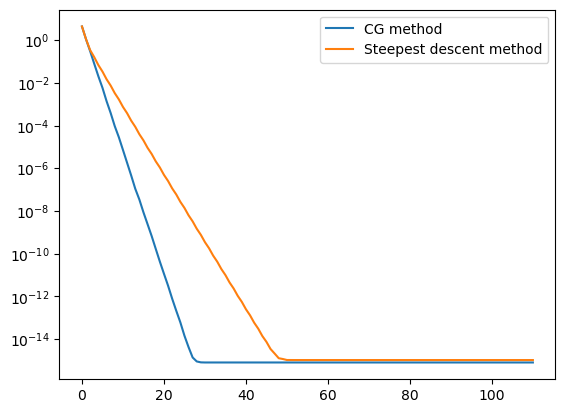

In [21]:
plt.semilogy(error_norm_cg, label='CG method')
plt.semilogy(error_norm_steepest, label='Steepest descent method')
plt.legend()

In [22]:
def prec_part(l, k):
    """
    Build the partial preconditioner matrix for given l and k.
    """
    # Initialize P of size (2^l) × (2^(l-k))
    P = np.zeros((2**l, 2**(l-k)), dtype=float)

    # ξ: vector [2^k, 2^k-1, …, 1] scaled by 2^(−k)
    xi = 2.0**(-k) * np.arange(2**k, 0, -1, dtype=float)

    # η: vector [0, 1, …, 2^k−1] scaled by 2^(−k)
    eta = 2.0**(-k) * np.arange(0, 2**k, dtype=float)

    # Fill columns with ξ
    for j in range(2**(l-k)):
        start = j * 2**k
        end   = start + 2**k
        P[start:end, j] = xi

    # Fill the next column (shifted down) with η
    for j in range(2**(l-k) - 1):
        start = j * 2**k
        end   = start + 2**k
        P[start:end, j+1] = eta

    return P

def precond(l, q):
    """
    Build the full preconditioner by summing C * C^T
    for k = 0…q, where C = prec_part(l, k).
    """
    # Initialize full P of size (2^l) × (2^l)
    P = np.zeros((2**l, 2**l), dtype=float)

    # Sum over k = 0…q of C * C^T
    for k in range(q+1):
        C = prec_part(l, k)
        P += C @ C.T

    return P


In [23]:
def precond_cg_method(A, P_inv, b, x0, max_iter=10000):
    n = A.shape[0]
    assert len(b) == n
    assert len(x0) == n
    assert P_inv.shape[0] == P_inv.shape[1] == n 
    assert A.shape[0] == A.shape[1]

    # Save all iterates, would not be done in production code
    x = np.zeros((max_iter + 1, n))
    r = np.zeros((max_iter + 1, n))

    x[0] = x0
    r[0] = b - A @ x0
    z = P_inv @ r[0]
    v = z
    for i in range(max_iter):
        alpha = (r[i].T @ z) / (v.T @ A @ v)
        x[i+1] = x[i] + alpha * v
        r[i+1] = r[i] - alpha * A @ v
        z_new = P_inv @ r[i+1]
        beta = (r[i+1].T @ z_new) / (r[i].T @ z)
        v = z_new + beta * v
        z = z_new
    return x, r

In [24]:
l = 7
n = 2**l
q = 3
assert q <= l
A = make_tridiagonal(n, -1, 2, -1)
P_inv= precond(l,q)
b = np.ones(n)
x0 = np.random.rand(n)
x_sol = np.linalg.solve(A, b)
x_prec_cg, residuals_prec_cg = precond_cg_method(A, P_inv, b, x0, max_iter=n)
x_normal_cg, residuals_normal_cg = cg_method(A, b, x0, max_iter=n)

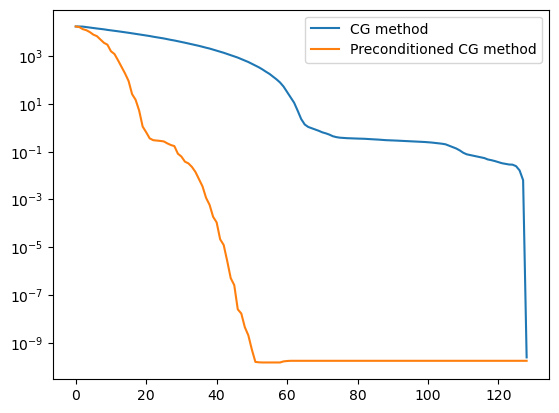

In [25]:
error_norm_normal_cg = norm(x_sol - x_normal_cg, axis=1)
error_norm_prec_cg = norm(x_sol - x_prec_cg, axis=1)

plt.semilogy(error_norm_normal_cg, label='CG method')
plt.semilogy(error_norm_prec_cg, label='Preconditioned CG method')
plt.legend()
plt.show()